Install Julia if running on Google Colab

In [ ]:
%%capture
%%shell
wget -O - https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/docs/src/examples/colab.sh
"""
This should take around one minute to finish. Once it does, change the runtime to `Julia` by choosing `Runtime` 
from the toolbar then `Change runtime type`. You can then delete this cell.
"""

Install needed packages

In [ ]:
ENV["JULIA_PKG_SERVER"] = ""

using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add(["DataFrames", "Plots", "Colors", "CategoricalArrays", "Random", 
         "Imbalance", "MLJBase", "TableTransforms", "ScientificTypes", "HTTP"])
         
using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using ScientificTypes
using TableTransforms
using CSV
using HTTP: download

### 1. Generate Random Data

Install Julia if running on Google Colab

In [ ]:
%%capture
%%shell
wget -O - https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/docs/src/examples/colab.sh
"""
This should take around one minute to finish. Once it does, change the runtime to `Julia` by choosing `Runtime` 
from the toolbar then `Change runtime type`. You can then delete this cell.
"""

Install needed packages

Let's start by generating some random imbalanced data. Here we generate data where there are three classes `0, 1, 2` that occur with probability `0.5, 0.2, 0.3` respectively, making `0` the majority class. The data has `4` continuous features and `4` categorical features where the categorical variables have `3, 4, 2, 5` unique values respectively.

In [2]:
rng = Random.default_rng()

num_rows = 200
num_cont_feats = 4
class_probs = [0.5, 0.2, 0.3]
means = [0.0 0.5 1.5]
num_vals_per_category = [3, 4, 2, 5]

X, y = generate_imbalanced_data(num_rows, num_cont_feats; means, class_probs, num_vals_per_category, rng=10)
X = DataFrame(X)

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.613,1.48,1.565,1.514,2.0,1.0,2.0,5.0
2,1.571,1.501,1.563,1.66,3.0,4.0,2.0,4.0
3,0.147,0.148,0.606,0.495,2.0,2.0,1.0,1.0
4,-0.105,-0.084,0.017,0.029,3.0,2.0,2.0,2.0
5,0.028,0.135,0.194,-0.141,3.0,3.0,1.0,2.0
6,-0.258,-0.281,0.219,-0.076,3.0,4.0,1.0,4.0
7,1.066,0.378,0.23,0.486,2.0,1.0,2.0,1.0
8,0.093,-0.203,-0.076,0.0,1.0,1.0,2.0,5.0
9,1.725,1.491,1.517,1.637,3.0,4.0,2.0,4.0


We follow by coercing the columns with few values (i.e., the categorical ones) to the appropriate type (a finite `sci-type` such as `OrderedFactor` or `Multiclass`). This is necessary because the `RandomWalkOversampling` assumes that all categorical features have `sci-type` finite.

In [3]:
X = coerce(X, autotype(X, :few_to_finite))

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…
1,1.613,1.48,1.565,1.514,2.0,1.0,2.0,5.0
2,1.571,1.501,1.563,1.66,3.0,4.0,2.0,4.0
3,0.147,0.148,0.606,0.495,2.0,2.0,1.0,1.0
4,-0.105,-0.084,0.017,0.029,3.0,2.0,2.0,2.0
5,0.028,0.135,0.194,-0.141,3.0,3.0,1.0,2.0
6,-0.258,-0.281,0.219,-0.076,3.0,4.0,1.0,4.0
7,1.066,0.378,0.23,0.486,2.0,1.0,2.0,1.0
8,0.093,-0.203,-0.076,0.0,1.0,1.0,2.0,5.0
9,1.725,1.491,1.517,1.637,3.0,4.0,2.0,4.0


### 2. Apply Random Walk Oversampling

#### Using Imbalance Only

Applying Random Walk Oversampling using the standard API is very straightforward. There only main hyperparameter is wanted ratios of each class relative to the majority class `ratios`. In the example below, we want all three classes to have `120%` of the data that was present in the majority class (i.e., class `0` prior to applying the algorithm)

In [4]:
Xover, yover = random_walk_oversample(X, y; ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:00



Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
  class:  0


(408×8 DataFrame
 Row │ Column1     Column2     Column3      Column4      Column5  Column6  Col ⋯
     │ Float64     Float64     Float64      Float64      Cat…     Cat…     Cat ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1.613       1.48        1.565        1.514       2.0      1.0      2.0 ⋯
   2 │  1.571       1.501       1.563        1.66        3.0      4.0      2.0
   3 │  0.147       0.148       0.606        0.495       2.0      2.0      1.0
   4 │ -0.105      -0.084       0.017        0.029       3.0      2.0      2.0
   5 │  0.028       0.135       0.194       -0.141       3.0      3.0      1.0 ⋯
   6 │ -0.258      -0.281       0.219       -0.076       3.0      4.0      1.0
   7 │  1.066       0.378       0.23         0.486       2.0      1.0      2.0
   8 │  0.093      -0.203      -0.076        0.0         1.0      1.0      2.0
  ⋮  │     ⋮           ⋮            ⋮            ⋮          ⋮        ⋮         ⋱
 402 │  0.116845    0.0

#### Using MLJ

To use `MLJ`, we first instantiate the model using keyword parameters, wrap it in a machine and the transform the machine with our input data `X,y`.

In [5]:
model = Imbalance.MLJ.RandomWalkOversampler(ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(model)
Xover, yover = transform(mach, X, y)

(408×8 DataFrame
 Row │ Column1     Column2     Column3      Column4      Column5  Column6  Col ⋯
     │ Float64     Float64     Float64      Float64      Cat…     Cat…     Cat ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1.613       1.48        1.565        1.514       2.0      1.0      2.0 ⋯
   2 │  1.571       1.501       1.563        1.66        3.0      4.0      2.0
   3 │  0.147       0.148       0.606        0.495       2.0      2.0      1.0
   4 │ -0.105      -0.084       0.017        0.029       3.0      2.0      2.0
   5 │  0.028       0.135       0.194       -0.141       3.0      3.0      1.0 ⋯
   6 │ -0.258      -0.281       0.219       -0.076       3.0      4.0      1.0
   7 │  1.066       0.378       0.23         0.486       2.0      1.0      2.0
   8 │  0.093      -0.203      -0.076        0.0         1.0      1.0      2.0
  ⋮  │     ⋮           ⋮            ⋮            ⋮          ⋮        ⋮         ⋱
 402 │  0.116845    0.0

#### Using TableTransforms

Let's consider an example with table transforms on a more realistic dataset. This time the categorical variables are strings so all we had to do is coerce `strings`to the `multiclass` type. `random_walk_oversample` will take of encoding them and decoding them before and after applying the actual algorithm.

In [14]:
# For TableTransforms
y_ind= 3
Xy, _ = generate_imbalanced_data(num_rows, num_cont_feats; means, class_probs, insert_y=y_ind, num_vals_per_category, rng=10)
Xy = coerce(Xy, autotype(Xy, :few_to_finite))

(Column1 = [1.613, 1.571, 0.147, -0.105, 0.028, -0.258, 1.066, 0.093, 1.725, 1.398  …  1.666, 1.675, 0.081, 1.516, 0.306, -0.201, 0.117, 0.25, 0.053, 0.158],
 Column2 = [1.48, 1.501, 0.148, -0.084, 0.135, -0.281, 0.378, -0.203, 1.491, 1.455  …  1.564, 1.498, -0.133, 1.406, 0.001, -0.228, 0.278, 0.216, 0.071, -0.067],
 Column3 = CategoricalValue{Float64, UInt32}[2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0  …  2.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 Column4 = [1.565, 1.563, 0.606, 0.017, 0.194, 0.219, 0.23, -0.076, 1.517, 1.506  …  1.523, 1.562, 0.127, 1.353, -0.079, 0.393, -0.172, 0.219, 0.182, 0.029],
 Column5 = [1.514, 1.66, 0.495, 0.029, -0.141, -0.076, 0.486, 0.0, 1.637, 1.594  …  1.765, 1.591, -0.071, 1.648, 0.053, 0.04, 0.076, 0.492, 0.064, 0.007],
 Column6 = CategoricalValue{Float64, UInt32}[2.0, 3.0, 2.0, 3.0, 3.0, 3.0, 2.0, 1.0, 3.0, 2.0  …  1.0, 3.0, 2.0, 3.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0],
 Column7 = CategoricalValue{Float64, UInt32}[1.0, 4.0, 2.0, 2.0, 3.0, 

Now we instantiate the model and simply pass the data to it using the pipeline operator `|>`. This is equivalent to calling `apply` from table transforms.

In [15]:
using Imbalance: TableTransforms.RandomWalkOversampler
model_t = RandomWalkOversampler(y_ind, ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> model_t

(Column1 = [1.613, 1.571, 0.147, -0.105, 0.028, -0.258, 1.066, 0.093, 1.725, 1.398  …  0.09172286838293076, -0.11781378835439682, 0.10679014772176743, 0.11684535443782806, 0.2556651830673218, 0.03279184550046921, -0.21939454972743988, -0.11700795590877533, 0.2833792567253113, -0.2019178867340088],
 Column2 = [1.48, 1.501, 0.148, -0.084, 0.135, -0.281, 0.378, -0.203, 1.491, 1.455  …  0.10150273889303207, -0.45141080021858215, -0.5355707406997681, 0.05849666893482208, -0.0632031261920929, -0.21711918711662292, -0.2295270413160324, -0.4738517701625824, -0.2189273238182068, 0.0963146761059761],
 Column3 = CategoricalValue{Float64, UInt32}[2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 Column4 = [1.565, 1.563, 0.606, 0.017, 0.194, 0.219, 0.23, -0.076, 1.517, 1.506  …  0.05646611750125885, -0.007926723919808865, -0.1493801325559616, 0.08707144856452942, -0.6094397306442261, -0.23070600628852844, 0.41287070512771606, 0.0116265239194035

### 3. Plot the Results

We can finally plot the data before and after to validate the results.

   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


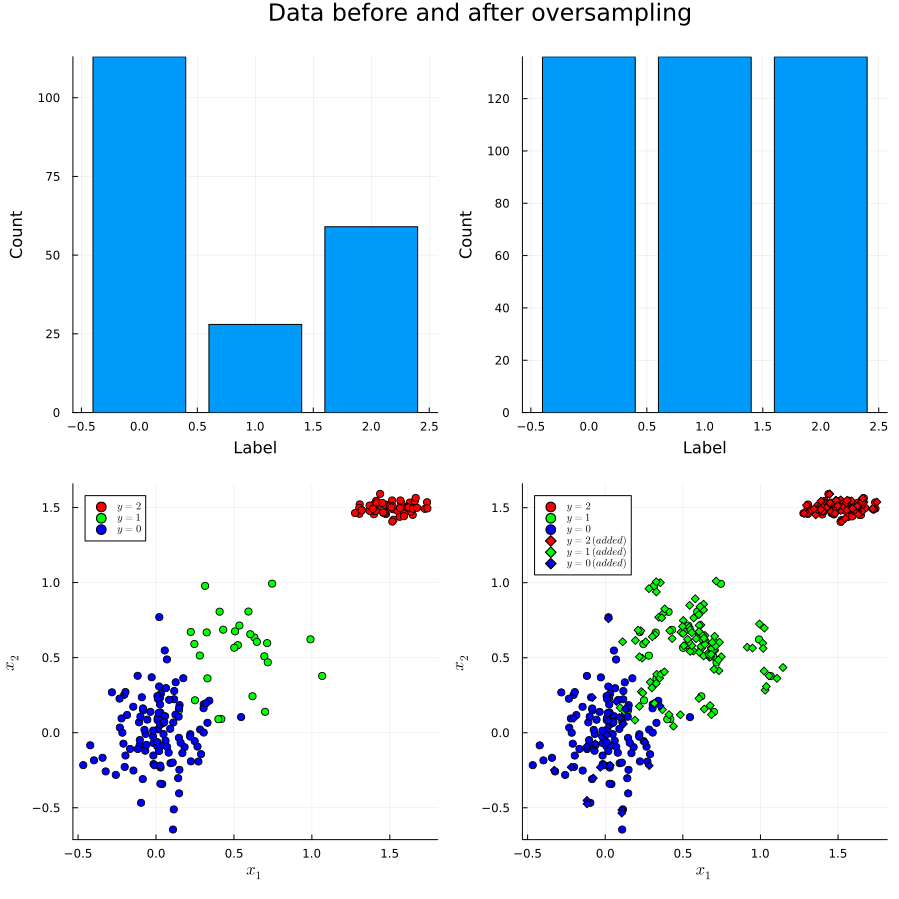

In [16]:
download("https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/examples/plot.jl", "./")
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, yover, X, Xover)

Plots.AnimatedGif("/Users/essam/Documents/GitHub/Imbalance.jl/examples/assets/random_walk_oversample.gif")
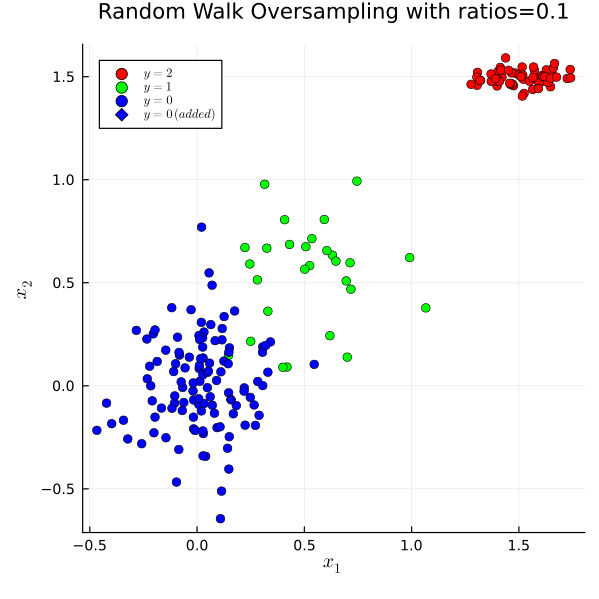

In [13]:
import Logging
Logging.disable_logging(Logging.Warn)

anim = @animate for ratios ∈ 0.1:0.05:3.0
	X_under, y_under = random_walk_oversample(X, y; ratios = ratios, rng = 42)
	plot_data(y, y_under, X, X_under; single_plot=true, 
			  single_plot_title="Random Walk Oversampling with ratios=$ratios")
end
gif(anim, (isdir("./assets")) ? "./assets/random_walk_oversample.gif" : "./random_walk_oversample.gif", fps=3)